# RAMP Urban Trees: Towards a Clinical Study

#### Authors: _Agnimo Yedidia, Amadei Tristan, Boutier Martin, Klein Antoine, Latournerie Louis, Remmache Yanis_

<div>
<table style="width:100%; background-color:transparent;">
  <tr style="background-color:transparent;">
    <td align="center"; style="background-color:transparent; width: 40%;">
        <a href="https://github.com/AntoineTSP/Ramp_challenge">
            <img src="./img/Urban_trees.png" width="450px"/>
        </a>
    </td>
  </tr>
 </table>
</div>

## Table of Contents
* [Introduction](#introduction)
* [The dataset](#dataset)
* [Base model](#base_model)
* [Submitting on RAMP](#submitting)

## Introduction <a class="anchor" id="introduction"></a>
The living environment is a subject of growing public attention. Indeed, we all aspire to live in a clean, peaceful and non-artificial environment. In the urban environment, one of these issues is the greening of streets. In this respect, trees play a crucial role in welcoming urban biodiversity, brightening up the landscape and lowering summer temperatures during heatwaves.

Except that, akin to all living organisms, these trees are not immutable and require ongoing monitoring and maintenance. The commune of Saint-Germain en Laye has taken on the responsibility of overseeing the health of its urban trees. The result is an open-source dataset <a href="https://www.data.gouv.fr/fr/datasets/arbres-urbains/"> (URL to the data.gouv website) </a> listing the positions, condition and species present on their territory.

We propose to use these measurements to assess the situation and carry out a study of the risks facing these trees. The aim is to gain a better understanding of the forces at work, so as to be in a better position to maintain this green heritage.

## The dataset <a class="anchor" id="dataset"></a>

This challenge contains a pdf file [legende-sgl-arbres-urbains.pdf](legende-sgl-arbres-urbains.pdf) (original labels in French) and a mardown file [dictionary-sgl-urbans-tree.md](dictionary-sgl-urbans-tree.md) (English) which explains the meaning of each abbreviation. We invite the reader to refer to them.
### Requirements

In [1]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedGroupKFold, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

### Data
Let's inspect what we have !

In [2]:
# Source : https://www.data.gouv.fr/fr/datasets/arbres-urbains/
data = pd.read_csv('./data/sgl-arbres-urbains-wgs84.csv')
data.head(5)

,ID_ARBRE,commune,quartier,site,cote_voirie,matricule_arbre,genre_arbre,espece_arbre,controle,situation,...,observation_travaux,type_delai_1,delai_annee_programmation,type_delai_2,delai_preconisation_2,delai_saison_programmation_2,delai_annee_programmation_2,reference_photo,Long,Lat
0,78551-Arbres-001,Saint Germain en Laye,Quartier 2 - Alsace - Pereire,Carrefour RN13,NaN,7,Betula,Alba,NaN,Groupe,...,NaN,NaN,NaN,b,NaN,b4,2022.0,259,2.074,48.899
1,78551-Arbres-002,Saint Germain en Laye,Quartier 2 - Alsace - Pereire,Carrefour RN13,NaN,8,Betula,Alba,NaN,Groupe,...,NaN,NaN,NaN,b,NaN,b4,2022.0,NaN,2.074,48.899
2,78551-Arbres-003,Saint Germain en Laye,Quartier 2 - Alsace - Pereire,Carrefour RN13,NaN,9,Betula,Alba,NaN,Groupe,...,NaN,NaN,NaN,b,NaN,b4,2022.0,NaN,2.074,48.899
3,78551-Arbres-004,Saint Germain en Laye,Quartier 2 - Alsace - Pereire,Carrefour RN13,NaN,1,Carpinus,Betulus - L. - Fastigiata,NaN,Bosquet,...,NaN,NaN,NaN,b,NaN,b4,2022.0,NaN,2.073,48.900
4,78551-Arbres-005,Saint Germain en Laye,Quartier 2 - Alsace - Pereire,Carrefour RN13,NaN,2,Carpinus,Betulus - L. - Fastigiata,NaN,Bosquet,...,NaN,NaN,NaN,b,NaN,b4,2022.0,NaN,2.074,48.899


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 709 entries, 0 to 708
Data columns (total 57 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ID_ARBRE                      709 non-null    object 
 1   commune                       709 non-null    object 
 2   quartier                      709 non-null    object 
 3   site                          709 non-null    object 
 4   cote_voirie                   545 non-null    object 
 5   matricule_arbre               709 non-null    int64  
 6   genre_arbre                   709 non-null    object 
 7   espece_arbre                  701 non-null    object 
 8   controle                      11 non-null     float64
 9   situation                     708 non-null    object 
 10  type_sol                      709 non-null    object 
 11  surf_permeable                709 non-null    float64
 12  date_plantation               709 non-null    int64  
 13  class

#### Observation: 
This is a dataset of 709 samples (as many measured trees) for which we have 57 features. 
Three types of information are immediately apparent: 
- numerical values, 
- comments written by the controllers,
- categorical variables. 

So, to complete the mission, we may have to use different methods, one for each type of information. (Classification + NLP)

In [4]:
data.columns

Index(['ID_ARBRE', 'commune', 'quartier', 'site', 'cote_voirie',
       'matricule_arbre', 'genre_arbre', 'espece_arbre', 'controle',
       'situation', 'type_sol', 'surf_permeable', 'date_plantation',
       'classe_age', 'hauteur', 'classe_hauteur', 'diametre',
       'circonference (en cm)', 'classe_circonference', 'port_arbre',
       'vigueur_pousse', 'champignon_collet', 'insecte_collet', 'plaie_collet',
       'observation_collet', 'champignon_tronc', 'insecte_tronc',
       'fissure_tronc', 'rejet_tronc', 'tuteurage_arbre', 'canisse_arbre',
       'plaie_tronc', 'observation_tronc', 'champignon_houppier',
       'insecte_houppier', 'fissure_houppier', 'ecorce_incluse_houppier',
       'bois_mort_houppier', 'plaie_houppier', 'observation_houppier',
       'esperance_maintien', 'contrainte', 'classification_diagnostic',
       'date_diagnostic', 'prescription_1', 'prescription_2', 'prescription_3',
       'observation_travaux', 'type_delai_1', 'delai_annee_programmation',
      

<Axes: >

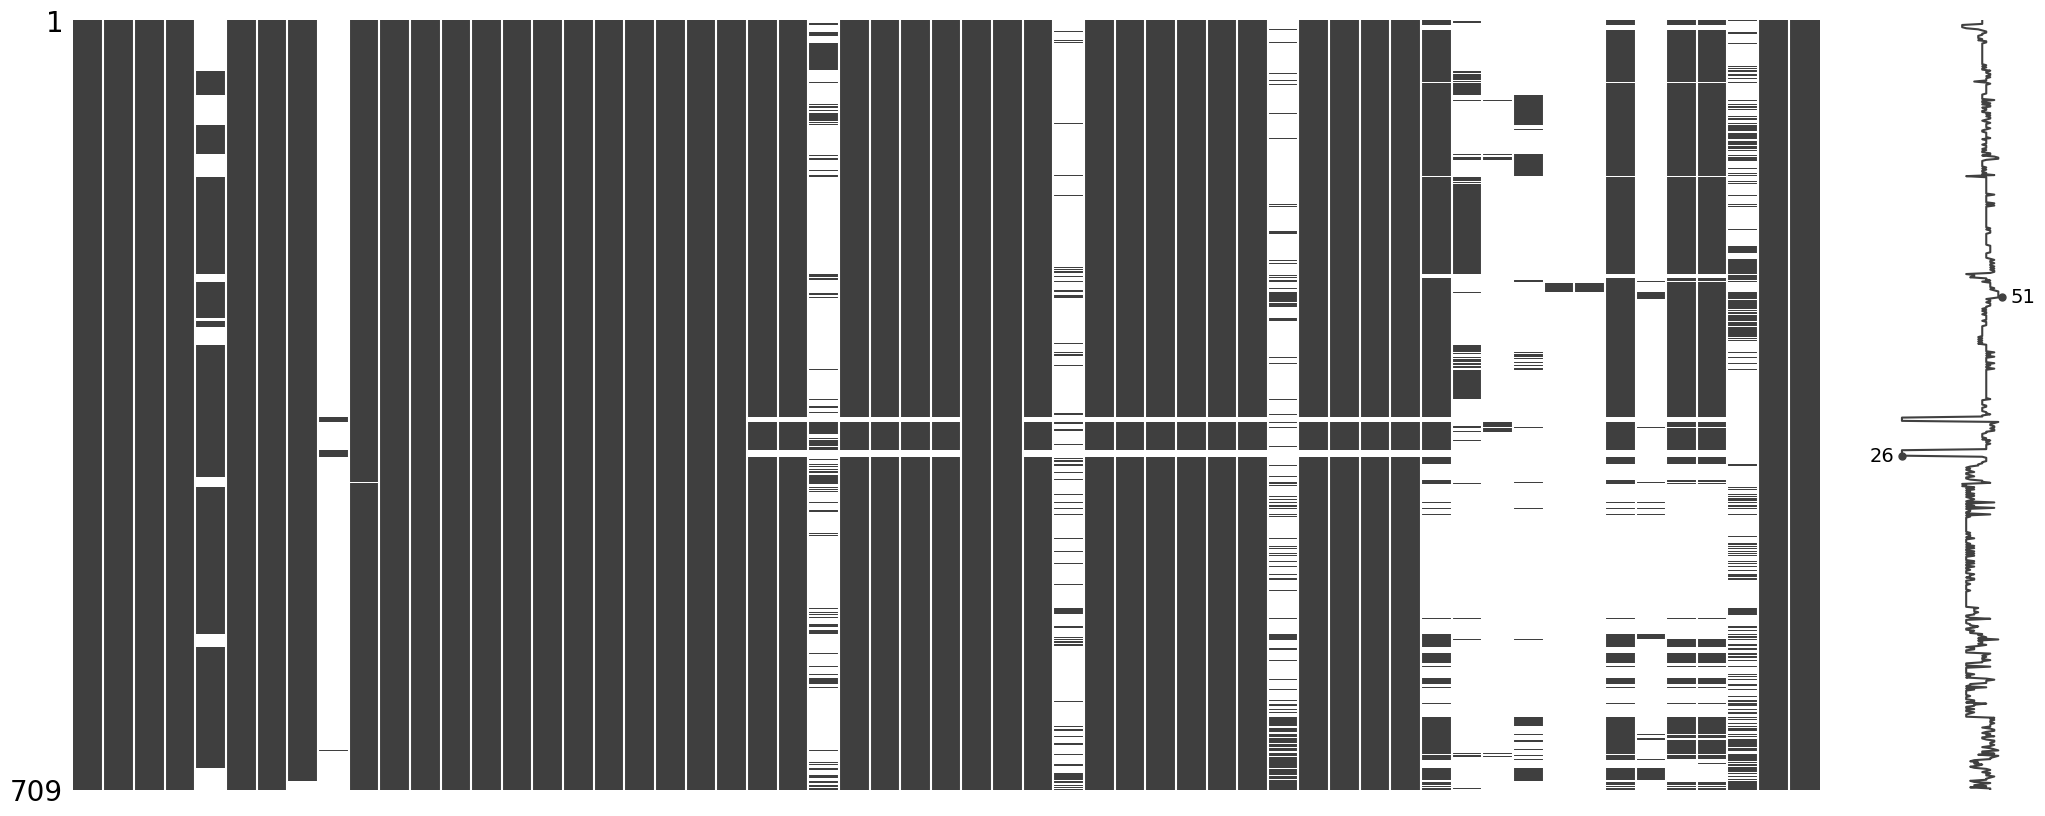

In [5]:
# Missingness
msno.matrix(data)

#### Obervation:
As is often the case with real data, we are confronted with missing data, particularly concerning remarks written by controllers. Does this mean that these trees have nothing to report, or that they should be imputed?

### Labels
Now let's look at the variable to be predicted: the tree diagnosis (`classification_diagnosis`).

In [6]:
print("There are {} distinct classes:".format(data.classification_diagnostic.nunique()))
print(data.classification_diagnostic.unique())

There are 5 distinct classes:
['C2' 'C1' 'C3' 'C4' nan 'C5']


In [7]:
data.classification_diagnostic.value_counts(dropna=False)

classification_diagnostic
C2     398
C1     237
C3      43
C4      11
NaN     10
C5      10
Name: count, dtype: int64

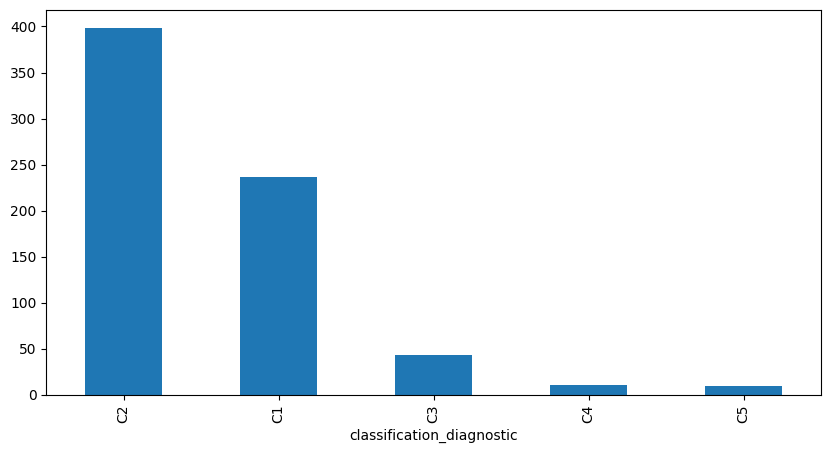

In [8]:
ax_pub = data.classification_diagnostic.value_counts(normalize=False).plot(kind='bar', figsize=(10, 5))

#### Observation:
We are dealing with a **unbalanced classification problem**. In fact, we count more healthy trees or trees with simple lesions that are not serious (C1 / C2) than trees with irreparable lesions requiring felling (C5). Is it suprising to you?

And yet, these are the most important cases in our study, as we would like to be able to **prevent rather than cure or replace**. 

This challenge requires you to handle ad-hoc balanced classification!

### Preprocessing of features
Let's devide them into the three categories we mentioned.

In [9]:
description_features_cat = [
    'type_sol',
    'classe_age',
    'classe_hauteur',
    'classe_circonference',
    'vigueur_pousse',
    'plaie_collet',
    'fissure_tronc',
    'plaie_tronc',
    'fissure_houppier',
    'bois_mort_houppier',
    'plaie_houppier',
    'prescription_1',
    'prescription_2',
    'prescription_3',
    'type_delai_1',
    'type_delai_2'
]
description_features_string = [
    "ID_ARBRE",
    'commune',
    'quartier',
    'site',
    'cote_voirie',
    'genre_arbre',
    'espece_arbre',
    'situation',
    'port_arbre',
    'champignon_collet',
    'insecte_collet',
    'observation_collet',
    'champignon_tronc',
    'insecte_tronc',
    'rejet_tronc',
    'tuteurage_arbre',
    'canisse_arbre',
    'observation_tronc',
    'champignon_houppier',
    'insecte_houppier',
    'ecorce_incluse_houppier',
    'observation_houppier',
    'contrainte',
    'date_diagnostic',
    'observation_travaux'
]
description_features_num = [
    'matricule_arbre',
    'controle',
    'surf_permeable',
    'date_plantation',
    'hauteur',
    'diametre',
    'circonference (en cm)',
    'esperance_maintien',
    'Long',
    'Lat'
]
target_features = ['classification_diagnostic']

In [10]:
data[description_features_num]

,matricule_arbre,controle,surf_permeable,date_plantation,hauteur,diametre,circonference (en cm),esperance_maintien,Long,Lat
0,7,NaN,5.0,2000,1000,63.661977,100,1.0,2.074,48.899
1,8,NaN,5.0,2000,1000,60.478878,95,1.0,2.074,48.899
2,9,NaN,5.0,2000,1000,54.112681,85,1.0,2.074,48.899
3,1,NaN,100.0,1980,1600,63.661977,100,1.0,2.073,48.900
4,2,NaN,100.0,1980,1600,190.985932,300,1.0,2.074,48.899
...,...,...,...,...,...,...,...,...,...,...
704,4,NaN,1.0,2000,500,22.281692,35,1.0,2.089,48.898
705,5,NaN,1.0,2017,500,12.732395,20,3.0,2.089,48.899
706,6,NaN,1.0,2000,500,25.464791,40,1.0,2.089,48.899
707,7,NaN,1.0,2019,500,15.915494,25,2.0,2.089,48.899


#### Observation
-We note that the numerical variables are not normalized. Is this necessary?

In [11]:
# We concatenate all of this into a nice datafame
X_cat = data[description_features_cat]
X_string = data[description_features_string]
X_num = data[description_features_num]
X = pd.concat([X_cat, X_string, X_num], axis=1)
y = data[target_features]

In [12]:
X

,type_sol,classe_age,classe_hauteur,classe_circonference,vigueur_pousse,plaie_collet,fissure_tronc,plaie_tronc,fissure_houppier,bois_mort_houppier,...,matricule_arbre,controle,surf_permeable,date_plantation,hauteur,diametre,circonference (en cm),esperance_maintien,Long,Lat
0,P,A,H2,C2,P,RCPLNS,TPF,TPLNC,HPF,HBMI,...,7,NaN,5.0,2000,1000,63.661977,100,1.0,2.074,48.899
1,P,A,H2,C2,P,RCPPL,TPF,TPLC,HPF,HBMI,...,8,NaN,5.0,2000,1000,60.478878,95,1.0,2.074,48.899
2,P,A,H2,C2,P,RCPPL,TPF,TPLCF,HPF,HBMI,...,9,NaN,5.0,2000,1000,54.112681,85,1.0,2.074,48.899
3,G,A,H4,C2,P,RCPPL,TPF,TPLS,HPF,HBMI,...,1,NaN,100.0,1980,1600,63.661977,100,1.0,2.073,48.900
4,G,A,H4,C6,P,RCPPL,TPF,TPLS,HPF,HBMI,...,2,NaN,100.0,1980,1600,190.985932,300,1.0,2.074,48.899
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
704,Gr,A,H1,C1,P,RCPPL,TPF,TPPL,HPF,HPBM,...,4,NaN,1.0,2000,500,22.281692,35,1.0,2.089,48.898
705,Gr,J,H1,C1,D,RCPPL,TPF,TPPL,HPF,HPBM,...,5,NaN,1.0,2017,500,12.732395,20,3.0,2.089,48.899
706,Gr,A,H1,C1,P,RCPPL,TPF,TPLNC,HPF,HPBM,...,6,NaN,1.0,2000,500,25.464791,40,1.0,2.089,48.899
707,Gr,J,H1,C1,PP,RCPPL,TPF,TPPL,HPF,HPBM,...,7,NaN,1.0,2019,500,15.915494,25,2.0,2.089,48.899


In [13]:
# Cardinalities
X.nunique().sort_values()

controle                     1
insecte_tronc                1
insecte_collet               1
insecte_houppier             1
commune                      1
type_delai_1                 1
rejet_tronc                  2
champignon_tronc             2
champignon_houppier          2
ecorce_incluse_houppier      2
cote_voirie                  2
contrainte                   2
type_delai_2                 2
champignon_collet            2
canisse_arbre                2
prescription_3               2
fissure_tronc                3
bois_mort_houppier           3
fissure_houppier             3
classe_age                   4
vigueur_pousse               4
situation                    4
tuteurage_arbre              4
esperance_maintien           4
plaie_houppier               5
port_arbre                   5
classe_hauteur               5
quartier                     6
plaie_tronc                  6
plaie_collet                 7
classe_circonference         7
observation_tronc            8
surf_per

In [14]:
def unique_values(df: pd.DataFrame, cols: list):
    "Print unique values for columns in `cols`."
    for col_name in cols:
        unique_values = df[col_name].unique()
        print(f"{col_name.upper()}\n{unique_values}\n")

observation_cols = X.columns[X.columns.str.startswith("obser")]
unique_values(X, observation_cols)

OBSERVATION_COLLET
[nan 'Cépée' 'Choc collet' 'Racine de surface abimée' 'Bidime'
 'Racine apparente' 'Fructification ganoderme'
 'Racine de surface / Choc collet' 'Drageons' 'Champignon collet '
 'Phellin du fruitier' ' Racine apparente' 'Échaudure' 'Autres']

OBSERVATION_TRONC
[nan 'Autres' 'Problème de coupe' 'Plaie longitudinale ' 'Cavité ouverte '
 'Échaudure ' 'Phellin du fruitier' 'Lierre' 'Tronc torsadé']

OBSERVATION_HOUPPIER
[nan 'Axe 3 Mort 2M Nord' 'Tuteur de formation'
 'Affaiblissement physiologique important' 'Branches cassées '
 'Cavité ouverte' 'Écorce incluse' 'Phellin du fruitier'
 'Réitération traumatique' 'Déchirure ' 'Échaudure'
 'Fissure ouverte axe2 2M Sud Est'
 'Axe2 dépassement dans la résidence mitoyenne' 'Plaie longitudinale'
 'Allongement des branches' 'Lierre' 'Bonne vigueur' 'Houppier clairsemé']

OBSERVATION_TRAVAUX
[nan 'coté cimetière ligne électrique' 'Branche déchirée'
 'Par rapport riverain' 'Ou abattage' 'retirer canisse'
 'Diminution façade charpe

In [15]:
binary_features = (X.nunique()[X.nunique(dropna=True) == 2]).index.to_list()
print(X[binary_features].apply(lambda x: x.unique()))

prescription_3                   [nan, RC, rg]
type_delai_2                       [b, nan, a]
cote_voirie                [nan, Pair, Impair]
champignon_collet                   [Non, Oui]
champignon_tronc               [Non, Oui, nan]
rejet_tronc                    [Non, Oui, nan]
canisse_arbre                       [Non, Oui]
champignon_houppier            [Non, Oui, nan]
ecorce_incluse_houppier        [Non, Oui, nan]
contrainte                     [Non, Oui, nan]
dtype: object


In [16]:
location_features = ["commune", "quartier", "site", "Lat", "Long"]
X[location_features]

,commune,quartier,site,Lat,Long
0,Saint Germain en Laye,Quartier 2 - Alsace - Pereire,Carrefour RN13,48.899,2.074
1,Saint Germain en Laye,Quartier 2 - Alsace - Pereire,Carrefour RN13,48.899,2.074
2,Saint Germain en Laye,Quartier 2 - Alsace - Pereire,Carrefour RN13,48.899,2.074
3,Saint Germain en Laye,Quartier 2 - Alsace - Pereire,Carrefour RN13,48.900,2.073
4,Saint Germain en Laye,Quartier 2 - Alsace - Pereire,Carrefour RN13,48.899,2.074
...,...,...,...,...,...
704,Saint Germain en Laye,Quartier 1 - Cœur de Ville et Quatier forestier,Place de la victoire,48.898,2.089
705,Saint Germain en Laye,Quartier 1 - Cœur de Ville et Quatier forestier,Place de la victoire,48.899,2.089
706,Saint Germain en Laye,Quartier 1 - Cœur de Ville et Quatier forestier,Place de la victoire,48.899,2.089
707,Saint Germain en Laye,Quartier 1 - Cœur de Ville et Quatier forestier,Place de la victoire,48.899,2.089


In [17]:
dates_features = X.columns[X.columns.str.startswith("date")]
unique_values(X, dates_features)

DATE_DIAGNOSTIC
['2020/10/22' '2020/10/07' '2020/10/12' '2020/10/16' '2020/10/21'
 '2020/10/23' '2020/11/13' '2020/10/19' '2020/10/20' '2020/06/10'
 '2020/11/16' '2020/11/12' '2020/07/27' '2020/11/18' nan '2020/11/19'
 '2020/11/23' '2020/11/27' '2020/11/24' '2020/11/25' '2020/12/16'
 '2020/12/18' '2020/12/15']

DATE_PLANTATION
[2000 1980 1990 2010 2015  200 2018 2019 2017 1970 1960 1995 1950]



Observations:

- What can be done with low-cardinality features, such as single-value features? (discard or ...?)

- Different types of variables exist, necessitating the use of appropriate data types for each. 
  - Is it feasible to extract valuable information from textual features, such as observation variables? How?
 
  - Location data could yield valuable insights, as issues may be correlated with specific geographic areas. Is it necessary to keep all related columns, or does redundancy exist within the dataset?

- Additionally, note that some categorical features have been created by recoding other numerical variables. Utilizing all of these features may not always be advantageous.

- It's might be wise to normalize string columns (case, whitespace, etc.) before recoding to ensure consistency and accuracy in the data preprocessing stage.

- Furthermore, outliers may be present and should be addressed. For instance, the presence of a value like `200` in the `date_plantation` column likely indicates an error that needs to be investigated and corrected.

In [18]:
print(y.shape)
print(y["classification_diagnostic"].unique())

(709, 1)
['C2' 'C1' 'C3' 'C4' nan 'C5']


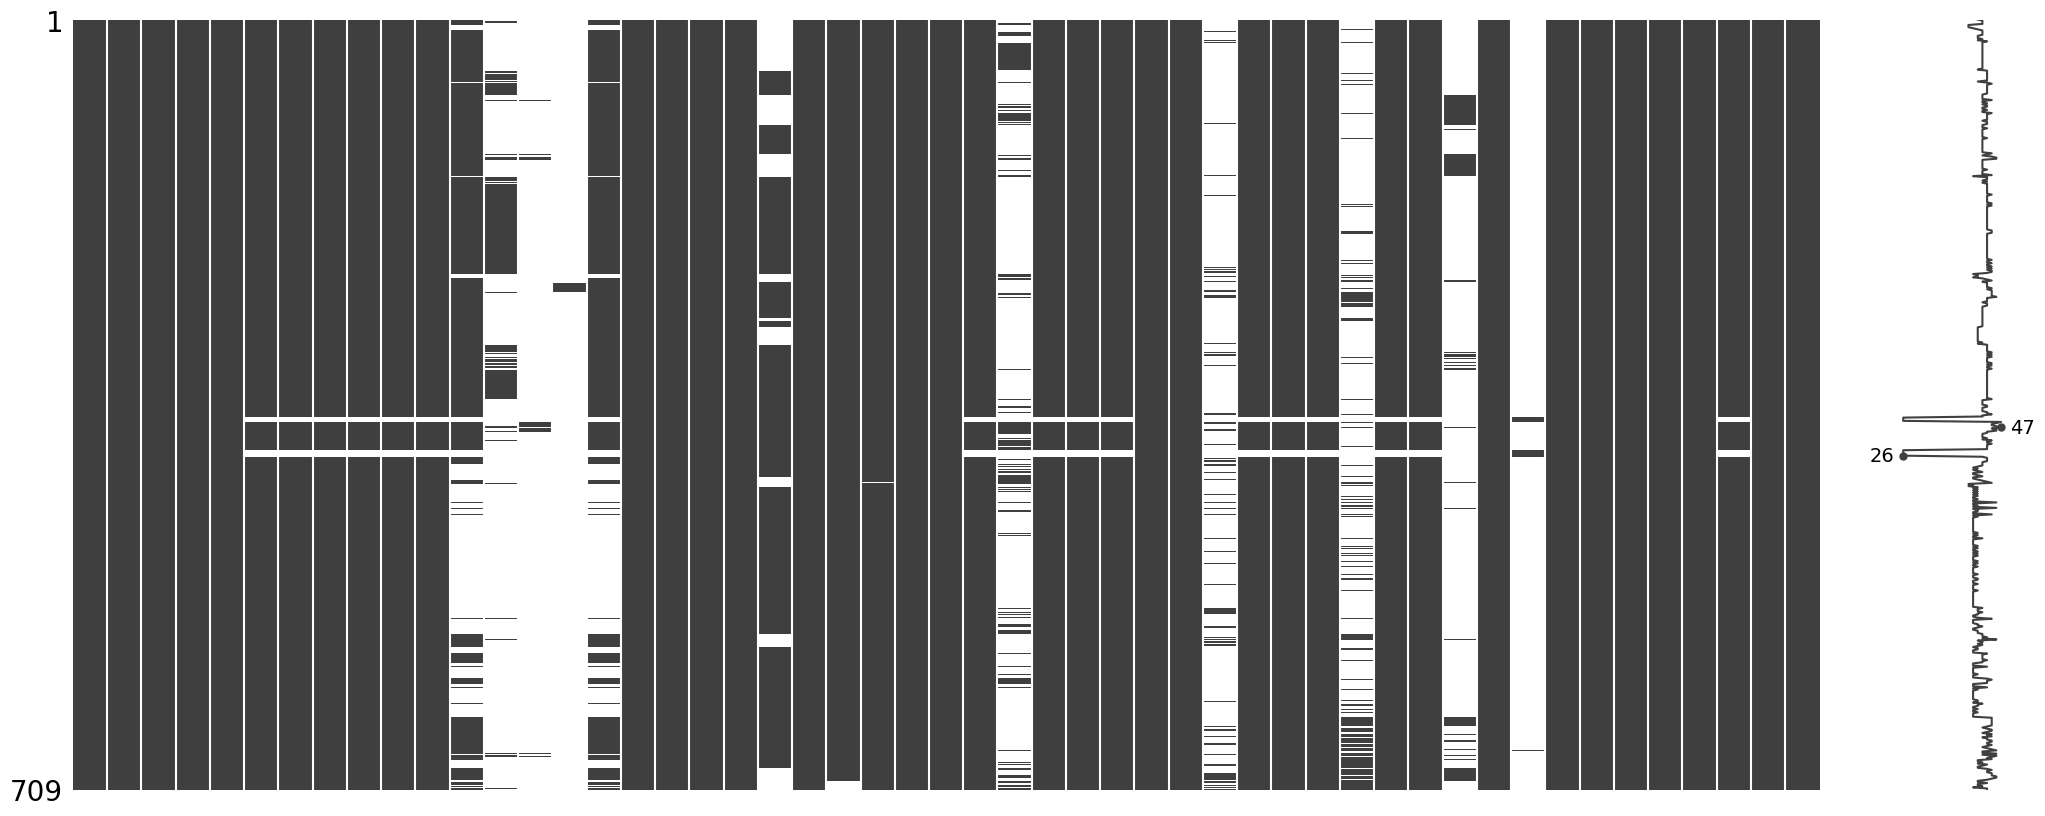

In [19]:
ax = msno.matrix(X)

In [20]:
# Hard code int_to_cat dict and retrieve cat_to_int with dictionary comprehension to use in all needed files
int_to_cat = {
    -1: "NaN",
    0: "C2",
    1: "C1",
    2: "C3",
    3: "C4",
    4: "C5"
}

cat_to_int = {v: k for k, v in int_to_cat.items()}

In [21]:
# We encode our target
y_encoded = np.array(y['classification_diagnostic'].map(cat_to_int).fillna(-1).astype('int8'))
np.unique(y_encoded), y_encoded.shape

(array([-1,  0,  1,  2,  3,  4], dtype=int8), (709,))

### Our baseline model <a class="anchor" id="base_model"></a>

In [22]:
# We split into train/test set
X_train, X_test, y_train , y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)

print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

X_train shape (496, 51)
y_train shape (496,)
X_test shape (213, 51)
y_test shape (213,)


In [23]:
print(pd.Series(y_test).value_counts(normalize=True).round(2))
print(pd.Series(y_train).value_counts(normalize=True).round(2))

 0    0.56
 1    0.33
 2    0.06
-1    0.01
 4    0.01
 3    0.01
Name: proportion, dtype: float64
 0    0.56
 1    0.33
 2    0.06
 3    0.02
 4    0.01
-1    0.01
Name: proportion, dtype: float64


In [24]:
y_train_series = pd.Series(y_train, name="classification_diagnostic").map(int_to_cat)
y_train_series.index = X_train.index
pd.concat([X_train, y_train_series], axis=1).to_csv("./data/train.csv")

In [25]:
y_test_series = pd.Series(y_test, name="classification_diagnostic").map(int_to_cat)
y_test_series.index = X_test.index
pd.concat([X_test, y_test_series], axis=1).to_csv("./data/test.csv")

In [26]:
# Let's define a simple pipeline as a simple model
string_transformer = ColumnTransformer(
    [
        (
            "string",
            OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1000),
            description_features_string,
        ),
        (
            "cat",
            OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1000),
            description_features_cat,
        ),
    ]
)

numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("scaler", StandardScaler()),
    ]
)
clf = Pipeline(
    steps=[
        ("encoder", string_transformer),
        ("transformer", numeric_transformer),
        ("classifier", RandomForestClassifier(random_state=42)),
    ]
)
clf.fit(X_train, y_train)
clf

Pipeline(steps=[('encoder',
                 ColumnTransformer(transformers=[('string',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1000),
                                                  ['ID_ARBRE', 'commune',
                                                   'quartier', 'site',
                                                   'cote_voirie', 'genre_arbre',
                                                   'espece_arbre', 'situation',
                                                   'port_arbre',
                                                   'champignon_collet',
                                                   'insecte_collet',
                                                   'observation_collet',
                                                   'champignon_tronc',
                                                   'insecte_tronc',
                                                   'rejet_tr...
                                                   'plaie_collet',
                                                   'fissure_tronc',
                                                   'plaie_tronc',
                                                   'fissure_houppier',
                                                   'bois_mort_houppier',
                                                   'plaie_houppier',
                                                   'prescription_1',
                                                   'prescription_2',
                                                   'prescription_3',
                                                   'type_delai_1',
                                                   'type_delai_2'])])),
                ('transformer',
                 Pipeline(steps=[('imputer',
                                  SimpleImputer(strategy='most_frequent')),
                                 ('scaler', StandardScaler())])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [27]:
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.8967136150234741

In [28]:
print(classification_report(y_test, y_pred, zero_division=0.))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00         3
           0       0.88      0.96      0.92       120
           1       0.93      0.94      0.94        71
           2       1.00      0.31      0.47        13
           3       0.67      0.67      0.67         3
           4       0.00      0.00      0.00         3

    accuracy                           0.90       213
   macro avg       0.75      0.65      0.67       213
weighted avg       0.89      0.90      0.88       213



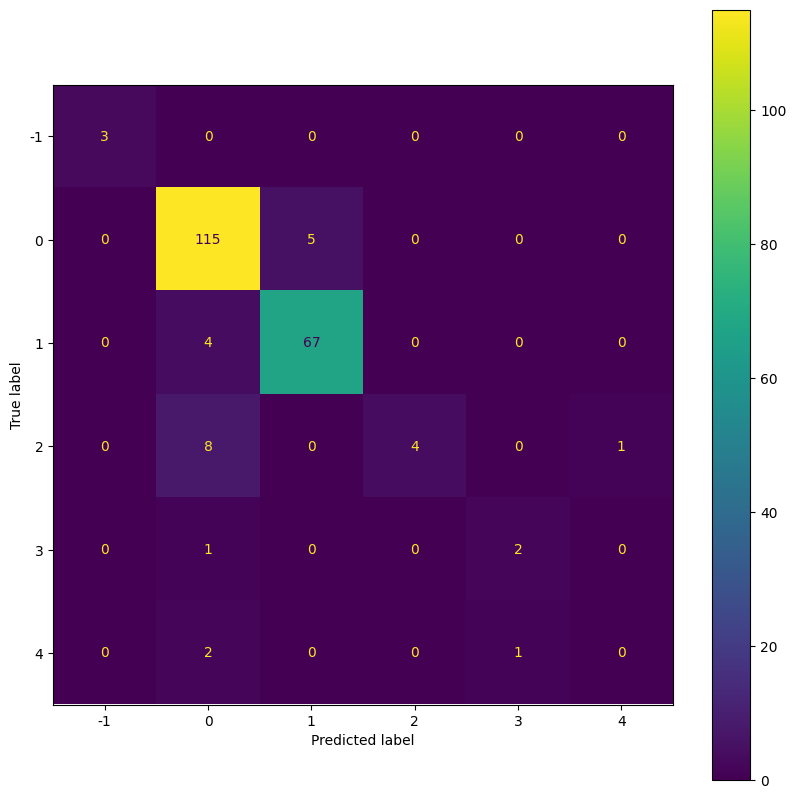

In [29]:
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
fig = disp.figure_
fig.set_figwidth(10)
fig.set_figheight(10)  

#### Observation:
We naively see good performance with a simple ramdom forest. However, don't get us wrong, the problem was unbalanced and we can see from the confusion matrix that errors are always made on the same class!

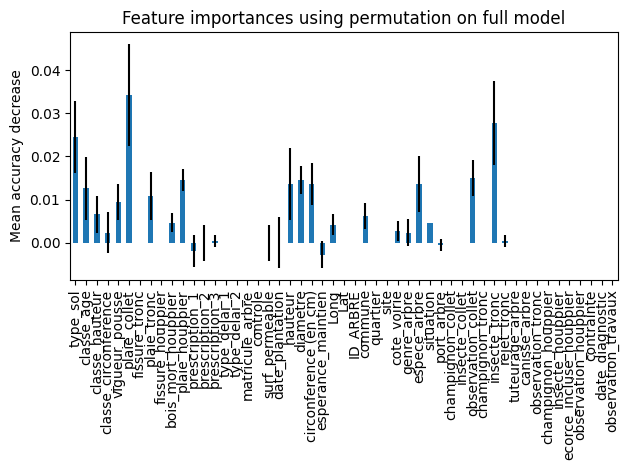

In [30]:
#Let's find our which features contributes the most to the diagnosis
result = permutation_importance(
    clf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
forest_importances = pd.Series(result.importances_mean,
                                index=description_features_cat+
                               description_features_num+
                               description_features_string)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [31]:
balanced_accuracy_score(y_test, y_pred)

0.6460590465872157

#### Observation
- It comes as no surprise that information such as the presence of insects, trunk circumference, and species are crucial for diagnosing and consequently predicting the tree's condition. However, is this the entirety of the narrative?
- Additionally, we have included all variables without filtering. Some of these clearly pose a risk of leakage for the model and threaten its generalizability while other capture the same information. Exercise caution and avoid such pitfalls.
- As anticipated, the balanced performance of our initial model is not particularly strong (0.64% for 6 classes). The onus is now on you to achieve better results!

## Submitting to the online challenge: [ramp.studio](https://ramp.studio) <a class="anchor" id="submitting"></a>

Once you found a good model, you can submit them to [ramp.studio](https://www.ramp.studio) to enter the online challenge. First, if it is your first time using the RAMP platform, [sign up](https://www.ramp.studio/sign_up), otherwise [log in](https://www.ramp.studio/login). Then sign up to the event [urban trees](https://github.com/AntoineTSP/Ramp_challenge). Both signups are controled by RAMP administrators, so there **can be a delay between asking for signup and being able to submit**.

Once your signup request is accepted, you can go to your [sandbox]() and write the code for your classifier directly on the browser. You can also create a new folder `my_submission` in the `submissions` folder containing `classifier.py` and upload this file directly. You can check the starting-kit ([`classifier.py`](/edit/submissions/starting_kit/classifier.py)) for an example. The submission is trained and tested on our backend in the similar way as `ramp-test` does it locally. While your submission is waiting in the queue and being trained, you can find it in the "New submissions (pending training)" table in [my submissions](). Once it is trained, your submission shows up on the [public leaderboard](). 
If there is an error (despite having tested your submission locally with `ramp-test`), it will show up in the "Failed submissions" table in [my submissions](). You can click on the error to see part of the trace.

The data set we use at the backend is usually different from what you find in the starting kit, so the score may be different.

The usual way to work with RAMP is to explore solutions, add feature transformations, select models, etc., _locally_, and checking them with `ramp-test`. The script prints mean cross-validation scores.

The official score in this RAMP (the first score column on the [leaderboard]() is the balenced accuracy score (`bal_acc`). When the score is good enough, you can submit it at the RAMP.

### Submit
Here is the script proposed as the starting_kit:

In [32]:
%%writefile submissions/starting_kit/classifier.py

from sklearn.base import BaseEstimator
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier

description_features_cat = ["type_sol",
                            'classe_age',
                            'classe_hauteur',
                            'classe_circonference',
                            'vigueur_pousse',
                            'plaie_collet',
                            'fissure_tronc',
                            'plaie_tronc',
                            'fissure_houppier',
                            'bois_mort_houppier',
                            'plaie_houppier',
                            'prescription_1',
                            'prescription_2',
                            'prescription_3',
                            'type_delai_1',
                            'type_delai_2']
description_features_string = ["ID_ARBRE",
                               'commune',
                               'quartier',
                               'site',
                               'cote_voirie',
                               'genre_arbre',
                               'espece_arbre',
                               'situation',
                               'port_arbre',
                               'champignon_collet',
                               'insecte_collet',
                               'observation_collet',
                               'champignon_tronc',
                               'insecte_tronc',
                               'rejet_tronc',
                               'tuteurage_arbre',
                               'canisse_arbre',
                               'observation_tronc',
                               'champignon_houppier',
                               'insecte_houppier',
                               'ecorce_incluse_houppier',
                               'observation_houppier',
                               'contrainte',
                               'date_diagnostic',
                               'observation_travaux'
                               ]
description_features_num = ['matricule_arbre',
                            'controle',
                            'surf_permeable',
                            'date_plantation',
                            'hauteur',
                            'diametre',
                            'circonference (en cm)',
                            'esperance_maintien',
                            'Long',
                            'Lat'
                            ]
target_features = ['classification_diagnostic']


class Classifier(BaseEstimator):
    def __init__(self):
        self.string_transformer = ColumnTransformer(
            [("string",
              OrdinalEncoder(handle_unknown='use_encoded_value',
                             unknown_value=-1000),
              description_features_string),
             ("cat",
              OrdinalEncoder(handle_unknown='use_encoded_value',
                             unknown_value=-1000), description_features_cat)], 
            remainder="drop")

        self.numeric_transformer = Pipeline(
            steps=[("imputer", SimpleImputer(strategy="median")),
                   ("scaler", StandardScaler())])

        self.model = RandomForestClassifier(random_state=42)

        self.pipe = make_pipeline(
            self.string_transformer,
            self.numeric_transformer,
            self.model)

    def fit(self, X, y):
        self.pipe.fit(X, y)

    def predict(self, X):
        return self.pipe.predict(X)

    def predict_proba(self, X):
        return self.pipe.predict_proba(X)
    

Overwriting submissions/starting_kit/classifier.py


You can test your solution locally by running the ramp-test command followed by --submission <my_submission folder>.

Here is an example with the starting_kit submission:

Don't forget to install the ramp library with the command:

!pip install ramp-workflow

In [34]:
!ramp-test --submission starting_kit

Testing Urban trees: Towards a Clinical Study
Reading train and test files from ./data/ ...
Reading cv ...
Training submissions\starting_kit ...
CV fold 0
	score  bal_acc    acc      time
	train    1.000  1.000  0.449999
	valid    0.385  0.384  0.086000
	test     0.755  0.753  0.048999
CV fold 1
	score  bal_acc    acc      time
	train    1.000  1.000  0.279001
	valid    0.331  0.757  0.038001
	test     0.728  0.903  0.086998
CV fold 2
	score  bal_acc    acc      time
	train    1.000  1.000  0.292000
	valid    0.553  0.498  0.043000
	test     0.825  0.800  0.073005
----------------------------
Mean CV scores
----------------------------
	score         bal_acc             acc        time
	train       1.0 ± 0.0       1.0 ± 0.0  0.3 ± 0.08
	valid  0.423 ± 0.0944  0.546 ± 0.1561  0.1 ± 0.02
	test   0.769 ± 0.0408  0.819 ± 0.0625  0.1 ± 0.02
----------------------------
Bagged scores
----------------------------
	score  bal_acc    acc
	valid    0.418  0.559
	test     0.939  0.932
